## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as st
import math
import seaborn as sns
import matplotlib as plt
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
import sys
from sklearn import metrics
from sklearn import model_selection
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

Get the AReM Data Set

In [2]:
fdir = {}
for folder,subfolders,file in os.walk("../data/ARem"):
    for sub in subfolders:
        fpath = "../data/ARem/" + sub
        files = os.listdir(fpath)
        fdir[sub] = files

In [3]:
def get_file_content(fname):
    fpath = "../data/ARem/" + fname
    fdf = pd.read_csv(fpath,skiprows=5,delimiter="[,\s+]",names=['time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'],engine="python")
    fdf = fdf.replace(np.nan, 0)
    return (fname,fdf)

In [4]:
test_data = {}
train_data = {}
all_instances = []
for folder,files in fdir.items():
    fmap = [folder+'/'+name for name in files]
    result = list(map(get_file_content,fmap))
    tst = []
    trn = []
    if folder == 'bending1' or folder == 'bending2':
        for f,r in result:
            if 'dataset1.csv' in f or 'dataset2.csv' in f:
                tst.append(r)
            else:
                trn.append(r)
            all_instances.append(r)
        test_data[folder] = tst
        train_data[folder] = trn
    else:
        for f,r in result:
            if 'dataset1.csv' in f or 'dataset2.csv' in f or 'dataset3.csv' in f:
                tst.append(r)
            else:
                trn.append(r)
            all_instances.append(r)
        test_data[folder] = tst
        train_data[folder] = trn

In [5]:
trn_ind = [2,3,4,5,6,9,10,11,12]
trn_ind.extend(list(range(16,28)))
trn_ind.extend(list(range(31,43)))
trn_ind.extend(list(range(46,58)))
trn_ind.extend(list(range(61,73)))
trn_ind.extend(list(range(76,88)))

### (b) Splitting Data

In [6]:
all_instances

[       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0         0      39.25       0.43      22.75       0.43      33.75        1.3
 1       250      39.25       0.43      23.00       0.00      33.00        0.0
 2       500      39.25       0.43      23.25       0.43      33.00        0.0
 3       750      39.50       0.50      23.00       0.71      33.00        0.0
 4      1000      39.50       0.50      24.00       0.00      33.00        0.0
 ..      ...        ...        ...        ...        ...        ...        ...
 475  118750      43.33       0.47      25.00       0.00      30.00        0.0
 476  119000      43.50       0.50      25.50       0.50      30.00        0.0
 477  119250      43.50       0.50      24.75       0.43      30.00        0.0
 478  119500      43.50       0.50      24.33       0.47      30.00        0.0
 479  119750      43.50       0.50      24.25       0.43      30.00        0.0
 
 [480 rows x 7 columns],
        time  avg_rss12  

In [7]:
len(all_instances)

88

In [8]:
test_data

{'bending1': [       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
  0         0      39.25       0.43      22.75       0.43      33.75        1.3
  1       250      39.25       0.43      23.00       0.00      33.00        0.0
  2       500      39.25       0.43      23.25       0.43      33.00        0.0
  3       750      39.50       0.50      23.00       0.71      33.00        0.0
  4      1000      39.50       0.50      24.00       0.00      33.00        0.0
  ..      ...        ...        ...        ...        ...        ...        ...
  475  118750      43.33       0.47      25.00       0.00      30.00        0.0
  476  119000      43.50       0.50      25.50       0.50      30.00        0.0
  477  119250      43.50       0.50      24.75       0.43      30.00        0.0
  478  119500      43.50       0.50      24.33       0.47      30.00        0.0
  479  119750      43.50       0.50      24.25       0.43      30.00        0.0
  
  [480 rows x 7 columns],

In [9]:
train_data

{'bending1': [       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
  0         0      42.00       0.71      21.25       0.43      30.00       0.00
  1       250      41.50       0.50      20.25       1.48      31.25       1.09
  2       500      41.50       0.50      14.25       1.92      33.00       0.00
  3       750      40.75       0.83      15.75       0.43      33.00       0.00
  4      1000      40.00       0.71      20.00       2.74      32.75       0.43
  ..      ...        ...        ...        ...        ...        ...        ...
  475  118750      42.50       0.50      20.00       0.82      36.00       0.00
  476  119000      42.67       0.47      21.00       0.00      36.33       0.47
  477  119250      44.33       0.94      21.00       0.00      36.33       0.47
  478  119500      45.25       0.43      26.75       1.79      36.00       0.00
  479  119750      47.25       0.83      29.75       0.43      35.25       1.30
  
  [480 rows x 7 columns],

### (c) Feature Extraction

i. Research

The time-domain features are Mean, Median, Mode, Standard Deviation, Variance, Covariance, Zero Cross Rate, Minimum, Maximum, Root Mean Square, and Distance. The most commonly used time-domain features involved in time-series classification are minimum, maximum, mean, median, standard deviation, first quartile, and third quartile.


ii. Extraction

In [10]:
class FeatureExtraction():
    
    columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    
    def __init__(self,dataframe):
        self.df = dataframe
        self.mean = list(map(self.calculate_mean,FeatureExtraction.columns))
        self.median = list(map(self.calculate_median,FeatureExtraction.columns))
        self.min = list(map(self.calculate_min,FeatureExtraction.columns))
        self.max = list(map(self.calculate_max,FeatureExtraction.columns))
        self.quartiles = list(map(self.calculate_quartiles,FeatureExtraction.columns))
        self.std_dev = list(map(self.calculate_std_deviation,FeatureExtraction.columns))
        
    def calculate_mean(self,column):
        clist = list(self.df[column])
        csum = 0
        for data in clist:
            csum += data
        return csum/len(clist)
    
    def calculate_median(self,column):
        clist = list(self.df[column])
        clist.sort()
        return clist[int(len(clist)/2)]
    
    def calculate_min(self,column):
        clist = list(self.df[column])
        return min(clist)
    
    def calculate_max(self,column):
        clist = list(self.df[column])
        return max(clist)
    
    def calculate_quartiles(self,column):
        clist = list(self.df[column])
        clist.sort()
        n = len(clist)+1
        fq = int(n/4)
        tq = int((3*n)/4)
        return (clist[fq],clist[tq])
        
    def calculate_std_deviation(self,column):
        clist = list(self.df[column])
        pop_mean = self.mean[FeatureExtraction.columns.index(column)]
        vsum = 0
        for data in clist:
            vsum += ((data-pop_mean)**2)
        return ((vsum/len(clist))**0.5)
    
    def extract_features(self):
        features = []
        for i in range(0,6):
            features.append(self.min[i])
            features.append(self.max[i])
            features.append(self.mean[i])
            features.append(self.median[i])
            features.append(self.std_dev[i])
            fq,tq = self.quartiles[i]
            features.append(fq)
            features.append(tq)
        return features

In [11]:
fres = []
for dataframe in all_instances:
    fe = FeatureExtraction(dataframe)
    fres.append(fe.extract_features())
cnames = []
for i in range(1,7):
    cnames.append('min'+str(i))
    cnames.append('max'+str(i))
    cnames.append('mean'+str(i))
    cnames.append('median'+str(i))
    cnames.append('std_dev'+str(i))
    cnames.append('first_quart'+str(i))
    cnames.append('third_quart'+str(i))

In [12]:
res_df = pd.DataFrame(fres,columns=cnames)

In [13]:
res_df

min1   max1      mean1  median1  std_dev1  first_quart1  third_quart1  \
0   37.25  45.00  40.624792    40.50  1.475428         39.25         42.00   
1   38.00  45.67  42.812812    42.50  1.434054         42.00         43.67   
2   35.00  47.40  43.954500    44.33  1.557210         43.00         45.00   
3   33.00  47.75  42.179813    43.50  3.666840         39.20         45.00   
4   33.00  45.75  41.678063    41.75  2.241152         41.33         42.75   
..    ...    ...        ...      ...       ...           ...           ...   
83  20.75  46.25  34.763333    35.33  4.737266         31.67         38.25   
84  21.50  51.00  34.935813    35.50  4.641102         32.00         38.25   
85  18.33  47.67  34.333042    34.75  4.943612         31.25         38.00   
86  18.33  45.75  34.599875    35.25  4.726858         31.50         38.00   
87  15.50  43.67  34.225875    34.75  4.437168         31.25         37.25   

    min2   max2     mean2  ...  std_dev5  first_quart5  third_quart5  min6  \
0    0.0   1.30  0.358604  ...  2.186168         33.00         36.00   0.0   
1    0.0   1.22  0.372438  ...  1.993175         32.00         34.50   0.0   
2    0.0   1.70  0.426250  ...  1.997520         35.40         36.50   0.0   
3    0.0   3.00  0.696042  ...  3.845436         30.50         36.33   0.0   
4    0.0   2.83  0.535979  ...  2.408514         28.50         31.25   0.0   
..   ...    ...       ...  ...       ...           ...           ...   ...   
83   0.0  12.68  4.223792  ...  3.171372         14.25         18.33   0.0   
84   0.0  12.21  4.115750  ...  3.188731         14.25         18.25   0.0   
85   0.0  12.48  4.396958  ...  2.997366         13.75         18.00   0.0   
86   0.0  15.37  4.398833  ...  2.902659         14.00         18.25   0.0   
87   0.0  17.24  4.354500  ...  2.989801         14.33         18.25   0.0   

     max6     mean6  median6  std_dev6  first_quart6  third_quart6  
0    1.92  0.570583     0.43  0.582308          0.00          1.30  
1    3.11  0.571083     0.43  0.600383          0.00          1.30  
2    1.79  0.493292     0.43  0.512971          0.00          0.94  
3    2.18  0.613521     0.50  0.523771          0.00          1.00  
4    1.79  0.383292     0.43  0.388759          0.00          0.50  
..    ...       ...      ...       ...           ...           ...  
83   9.39  3.288271     3.27  1.645811          2.05          4.32  
84  10.21  3.280021     3.03  1.699145          2.12          4.50  
85   8.01  3.261583     3.00  1.615604          2.05          4.32  
86   8.86  3.289542     3.03  1.678418          2.12          4.26  
87   9.42  3.479542     3.27  1.759311          2.24          4.56  

[88 rows x 42 columns]

iii. Standard Deviation

In [14]:
def create_final_list(dev):
    fin = []
    for i in range(0,42):
        std,ci = dev[i]
        fin.append([std,ci])
    return fin

In [15]:
def get_std_ci_dataframe(data):
    return pd.DataFrame(data,columns=["Standard Deviation","90% Confidence Interval"],index=cnames)

METHOD 1 - Std deviation & confidence interval using normal distribution

In [16]:
def calc_std_dev_ci(column):
    clist = list(res_df[column])
    n = len(clist)
    csum = 0
    for data in clist:
        csum += data
    mean = csum/n
    vsum = 0
    for data in clist:
        vsum += ((data-mean)**2)
        
    std_dev = ((vsum/n)**0.5)
    
    fint,lint = st.norm.interval(alpha=0.90,loc=std_dev,scale=st.sem(clist)) # 90% confidence interval
    if math.isnan(fint) and math.isnan(lint):
        fint = 0.0
        lint = 0.0
    return (std_dev,(fint,lint))

In [17]:
std_devs = list(map(calc_std_dev_ci,cnames))

In [18]:
f_df = get_std_ci_dataframe(create_final_list(std_devs))

In [19]:
f_df

Standard Deviation                     90% Confidence Interval
min1                    9.515445       (7.837426596650285, 11.1934635372134)
max1                    4.369322      (3.598806278917894, 5.139838487007849)
mean1                   5.305314     (4.3697391314477265, 6.240889791031648)
median1                 5.405579        (4.452322272649749, 6.3588355693345)
std_dev1                1.760219    (1.4498101182730048, 2.0706282214761593)
first_quart1            6.115960        (5.037430225442618, 7.1944905453849)
third_quart1            5.101779      (4.202096614127416, 6.001461659645565)
min2                    0.000000                                  (0.0, 0.0)
max2                    5.033882       (4.14617265710144, 5.921590701224789)
mean2                   1.565194    (1.2891772243806092, 1.8412112797685227)
median2                 1.406753    (1.1586764054806669, 1.6548291631491057)
std_dev2                0.878152     (0.723292384483958, 1.0330108783316212)
first_quart2            0.942184    (0.7760325786264535, 1.1083347659367557)
third_quart2            2.120346    (1.7464298055486736, 2.4942623841691653)
min3                    2.939616    (2.4212240560647107, 3.4580079127717283)
max3                    4.847358     (3.992541762290641, 5.7021740600546975)
mean3                   3.985540     (3.2827028409486667, 4.688377505107412)
median3                 4.015148     (3.3070891801070768, 4.723206232982509)
std_dev3                0.940335    (0.7745097295924191, 1.1061598230617016)
first_quart3            4.196697     (3.4566225840554936, 4.936770811106583)
third_quart3            4.156693       (3.42367352240174, 4.889712747383943)
min4                    0.000000                                  (0.0, 0.0)
max4                    2.171183    (1.7883018444928875, 2.5540643019761093)
mean4                   1.159470    (0.9550007517461719, 1.3639382724491438)
median4                 1.140515    (0.9393889820150506, 1.3416414415848692)
std_dev4                0.455156    (0.3748904914203154, 0.5354210332196058)
first_quart4            0.840107    (0.6919566920262508, 0.9882570389669767)
third_quart4            1.545773      (1.273180620810579, 1.818364826717604)
min5                    6.089107      (5.015311979688952, 7.162901123232402)
max5                    5.708524      (4.701844301563293, 6.715204550648979)
mean5                   5.643253      (4.648083595705567, 6.638423161588122)
median5                 5.780031     (4.7607410736592595, 6.799321302848934)
std_dev5                1.017996    (0.8384755233874821, 1.1975161849547709)
first_quart5            6.063583      (4.99428908372678, 7.1328760867619145)
third_quart5            5.495511      (4.526395469045233, 6.464627389227532)
min6                    0.045577  (0.03753961287771656, 0.05361431877746958)
max6                    2.504568    (2.0628954285138787, 2.9462406410317614)
mean6                   1.148232    (0.9457447295163302, 1.3507187614206575)
median6                 1.082872    (0.8919110294167713, 1.2738331215098173)
std_dev6                0.514132   (0.42346619493771404, 0.6047971682827247)
first_quart6            0.754602     (0.6215306097840522, 0.887674051180684)
third_quart6            1.518537     (1.2507479080402637, 1.786326280730759)

METHOD 2 - Std deviation & confidence interval using python bootstrap

In [20]:
def calculate_std_ci(col):
    clist = list(res_df[col])
    data = (clist,)
    ci = st.bootstrap(data,np.std, confidence_level=0.90,random_state=1, method='percentile')
    return (np.std(clist),(ci.confidence_interval.low,ci.confidence_interval.high))

In [21]:
std = list(map(calculate_std_ci,cnames))

In [22]:
f_df2 = get_std_ci_dataframe(create_final_list(std))

In [23]:
f_df2

Standard Deviation                    90% Confidence Interval
min1                    9.515445    (8.208211982775044, 10.718896958349495)
max1                    4.369322    (3.3021239845619434, 5.277910058613254)
mean1                   5.305314     (4.683107803534193, 5.864954197652706)
median1                 5.405579    (4.770632344471795, 5.9811364943501335)
std_dev1                1.760219   (1.5599585675421908, 1.9285018458388747)
first_quart1            6.115960    (5.546698558286796, 6.6167694031617135)
third_quart1            5.101779     (4.289262949035632, 5.812129291030085)
min2                    0.000000                                 (0.0, 0.0)
max2                    5.033882     (4.598098619563009, 5.372569908578179)
mean2                   1.565194   (1.3881054913282045, 1.6980375821986526)
median2                 1.406753   (1.2337802810041556, 1.5386417543055586)
std_dev2                0.878152   (0.7971843518023746, 0.9362382111183127)
first_quart2            0.942184    (0.8278026267119865, 1.031330304431549)
third_quart2            2.120346     (1.890581057644242, 2.290346082865008)
min3                    2.939616    (2.743198978904695, 3.0897345836063055)
max3                    4.847358     (4.148241926127132, 5.435277211075663)
mean3                   3.985540    (3.3973100441025994, 4.471663629195143)
median3                 4.015148   (3.4152333187711825, 4.5213375621999194)
std_dev3                0.940335    (0.755118115403841, 1.1172445118509347)
first_quart3            4.196697    (3.6087562772374384, 4.678633388021364)
third_quart3            4.156693    (3.5253258052327276, 4.677806447065729)
min4                    0.000000                                 (0.0, 0.0)
max4                    2.171183   (1.9629494777671788, 2.3449904745236716)
mean4                   1.159470   (1.0686014304527671, 1.2163854678296664)
median4                 1.140515   (1.0499193876198667, 1.1973602567445798)
std_dev4                0.455156  (0.4183316408886997, 0.48301228893010306)
first_quart4            0.840107    (0.7723371458283173, 0.888247501170103)
third_quart4            1.545773   (1.4252898623789942, 1.6204919394352144)
min5                    6.089107    (4.3998165899830655, 7.457929923384244)
max5                    5.708524     (4.724509355701949, 6.527828087793701)
mean5                   5.643253    (4.412444426148962, 6.7097909503138755)
median5                 5.780031    (4.506666740663042, 6.8727941428292265)
std_dev5                1.017996    (0.8078528674307195, 1.214536241827977)
first_quart5            6.063583     (4.784054199642293, 7.176618332579832)
third_quart5            5.495511      (4.33913002240557, 6.506356522023541)
min6                    0.045577                 (0.0, 0.07802896990623483)
max6                    2.504568   (2.2393206771133576, 2.7419762161606016)
mean6                   1.148232     (1.055997790791538, 1.208589206671687)
median6                 1.082872   (0.9922347254208603, 1.1447000439980333)
std_dev6                0.514132  (0.47565275256266243, 0.5421414692601747)
first_quart6            0.754602   (0.6860011073297586, 0.8035986427406923)
third_quart6            1.518537   (1.3974546440402418, 1.5958209252018092)

iv. Select Features

We need to choose features that have clear decision boundaries in order to avoid overfitting an inaccurate results. Hence, we need to look for features with dense data distributions. In our case <strong>Max, Mean and 3rd quartile</strong>

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [24]:
plot_cnames = []
for i in [1,2,6]:
    plot_cnames.append("max"+str(i))
    plot_cnames.append("mean"+str(i))
    plot_cnames.append("third_quart"+str(i))
plot_df = res_df[plot_cnames]
for ind in plot_df.index:
    if ind not in trn_ind:
        plot_df = plot_df.drop(ind)
# adding column activity with an assumption that 1 = bending and 0 = non-bending
actv = [1]*9
actv.extend([0]*60)
plot_df['activity'] = actv

In [25]:
plot_df

max1      mean1  third_quart1   max2     mean2  third_quart2   max6  \
2   47.40  43.954500         45.00   1.70  0.426250          0.50   1.79   
3   47.75  42.179813         45.00   3.00  0.696042          1.12   2.18   
4   45.75  41.678063         42.75   2.83  0.535979          0.71   1.79   
5   48.00  43.454958         45.00   1.58  0.378083          0.50   5.26   
6   48.00  43.969125         44.67   1.50  0.413125          0.50   2.96   
..    ...        ...           ...    ...       ...           ...    ...   
83  46.25  34.763333         38.25  12.68  4.223792          5.73   9.39   
84  51.00  34.935813         38.25  12.21  4.115750          5.67  10.21   
85  47.67  34.333042         38.00  12.48  4.396958          5.76   8.01   
86  45.75  34.599875         38.00  15.37  4.398833          5.79   8.86   
87  43.67  34.225875         37.25  17.24  4.354500          5.78   9.42   

       mean6  third_quart6  activity  
2   0.493292          0.94         1  
3   0.613521          1.00         1  
4   0.383292          0.50         1  
5   0.679646          0.87         1  
6   0.555313          0.83         1  
..       ...           ...       ...  
83  3.288271          4.32         0  
84  3.280021          4.50         0  
85  3.261583          4.32         0  
86  3.289542          4.26         0  
87  3.479542          4.56         0  

[69 rows x 10 columns]

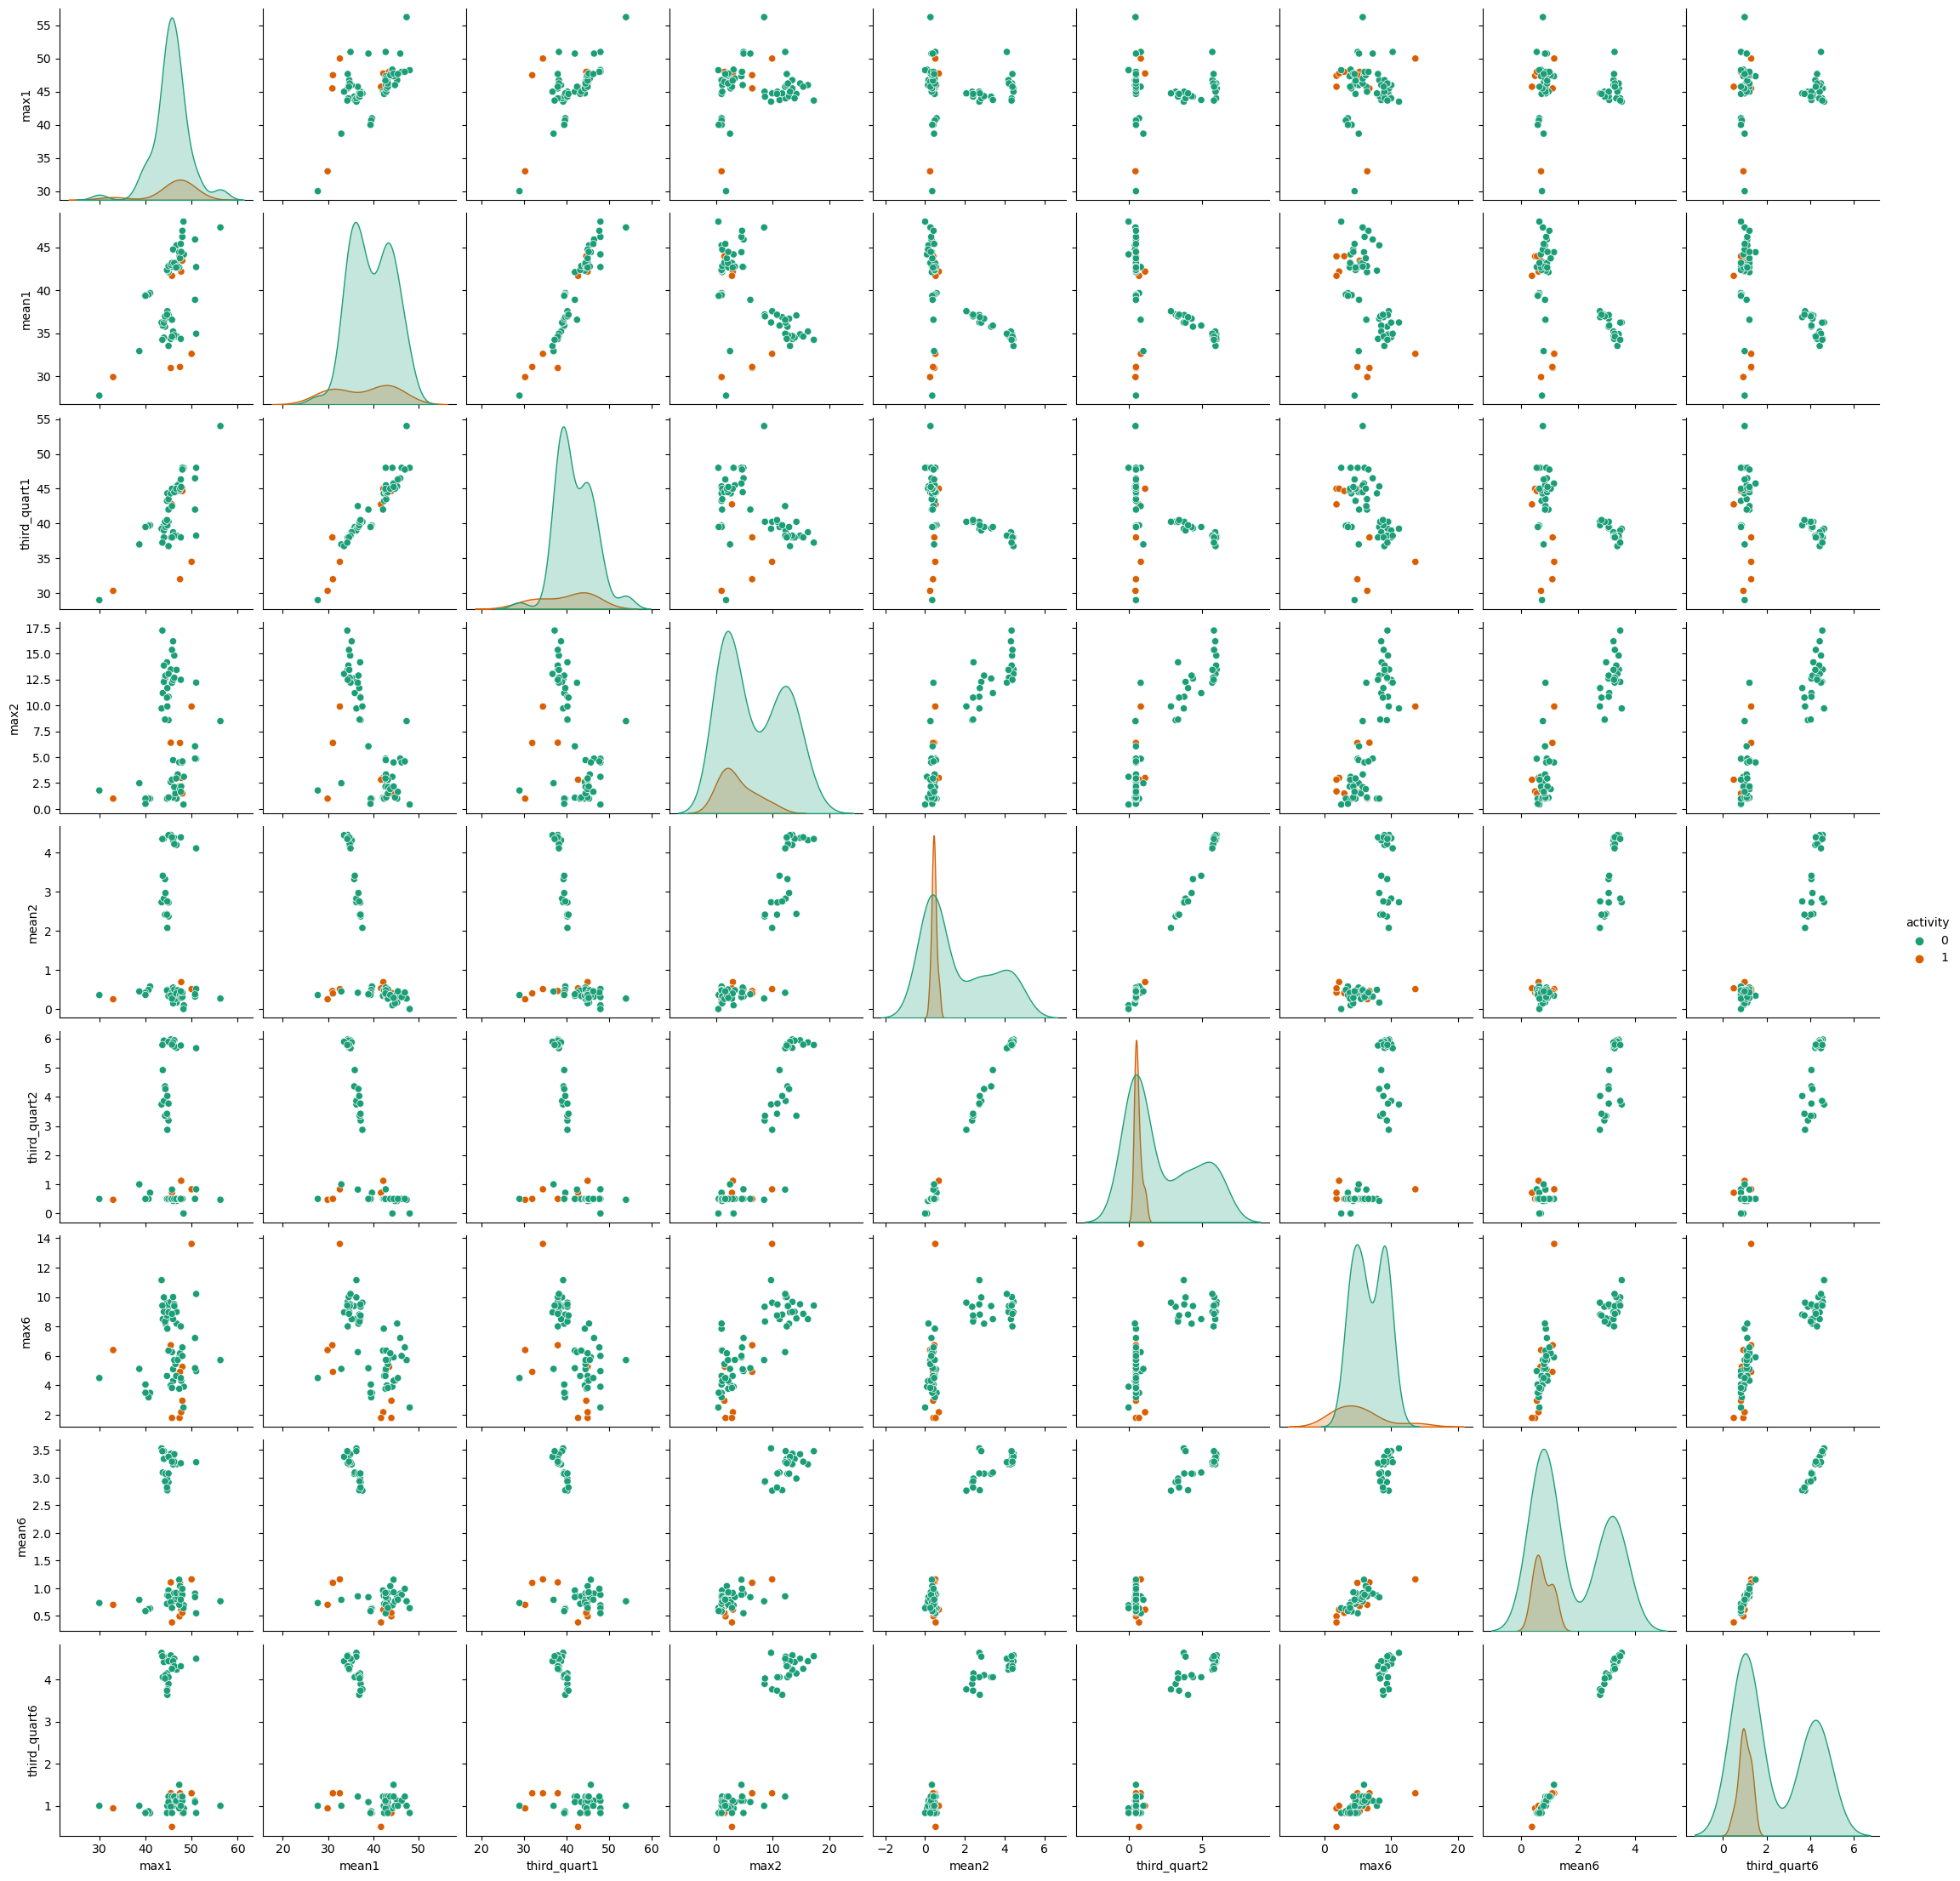

In [26]:
%matplotlib inline
sns.pairplot(plot_df, kind='scatter', hue="activity", palette="Dark2")

#### ii. Splitted Plots

In [27]:
class SplittedFeatures():
    
    def __init__(self,dataframe,ssize,columns):
        self.df = dataframe
        self.split_size = ssize
        self.columns = columns
        self.maximum,self.mean,self.quarts = self.generate_features_by_parts()
        
    def calculate_max_by_parts(self,clist):
        return max(clist)
        
    def calculate_mean_by_parts(self,clist):
        csum = 0
        for data in clist:
            csum += data
        return csum/len(clist)
    
    def calculate_quartiles_by_parts(self,clist):
        clist.sort()
        n = len(clist)+1
        fq = int(n/4)
        tq = int((3*n)/4)
        return (clist[fq],clist[tq])
        
    def generate_features_by_parts(self):
        maximum = []
        mean = []
        quarts = []
        for name in self.columns:
            clist = list(self.df[name])
            res = np.array_split(clist,self.split_size)
            res = [list(r) for r in res]
            maximum.append(list(map(self.calculate_max_by_parts,res)))
            mean.append(list(map(self.calculate_mean_by_parts,res)))
            quarts.append(list(map(self.calculate_quartiles_by_parts,res)))
        return (maximum,mean,quarts)
    
    def extract_features_by_parts(self):
        features = []
        j = 0
        for i in range(0,len(self.columns)):
            for j in range(0,self.split_size):
                features.append(self.maximum[i][j])
                features.append(self.mean[i][j])
                fq,tq = self.quarts[i][j]
                features.append(tq)
        return features

In [28]:
def generate_columns_by_parts(split_size):
    df_cnames = []
    for i in [1,2,6]:
        for j in range(1,split_size+1):
            df_cnames.append('max'+str(i)+'_'+str(j))
            df_cnames.append('mean'+str(i)+'_'+str(j))
            df_cnames.append('third_quart'+str(i)+'_'+str(j))
    return df_cnames

In [29]:
train_list = []
final_trn_list = []
for folder,files in train_data.items():
    train_list.extend(files)
for tdf in train_list:
    f = SplittedFeatures(tdf,2,['avg_rss12', 'var_rss12', 'var_rss23'])
    final_trn_list.append(f.extract_features_by_parts())
new_df = pd.DataFrame(final_trn_list,columns=generate_columns_by_parts(2))
# adding column activity with an assumption that 1 = bending and 0 = non-bending
actv = [1]*9
actv.extend([0]*60)
new_df['activity'] = actv

In [30]:
new_df

max1_1    mean1_1  third_quart1_1  max1_2    mean1_2  third_quart1_2  \
0    46.50  44.057167           45.00   47.40  43.851833           45.00   
1    47.75  43.278875           45.25   46.00  41.080750           44.50   
2    45.75  41.621208           44.25   43.67  41.734917           42.00   
3    48.00  44.117042           45.00   46.50  42.792875           43.00   
4    45.00  43.486208           44.50   48.00  44.452042           44.75   
..     ...        ...             ...     ...        ...             ...   
64   46.00  34.966250           38.75   46.25  34.560417           37.75   
65   45.67  34.737042           37.75   51.00  35.134583           38.50   
66   45.00  33.886458           37.50   47.67  34.779625           38.25   
67   44.00  34.836458           38.75   45.75  34.363292           37.50   
68   42.75  34.329333           37.67   43.67  34.122417           37.25   

    max2_1   mean2_1  third_quart2_1  max2_2   mean2_2  third_quart2_2  \
0     1.50  0.381042            0.50    1.70  0.471458            0.50   
1     3.00  0.673292            1.00    2.86  0.718792            1.25   
2     2.83  0.623083            0.83    1.12  0.448875            0.50   
3     1.30  0.250042            0.50    1.58  0.506125            0.50   
4     1.30  0.378667            0.50    1.50  0.447583            0.50   
..     ...       ...             ...     ...       ...             ...   
64   12.68  4.207958            5.76   12.09  4.239625            5.68   
65   12.21  4.217333            5.76   11.41  4.014167            5.41   
66   12.44  4.332208            5.68   12.48  4.461708            5.89   
67   12.38  4.257750            5.55   15.37  4.539917            6.02   
68   14.50  4.315917            5.61   17.24  4.393083            6.12   

    max6_1   mean6_1  third_quart6_1  max6_2   mean6_2  third_quart6_2  \
0     1.79  0.598250            1.00    1.50  0.388333            0.71   
1     1.53  0.640958            1.22    2.18  0.586083            0.87   
2     1.79  0.419083            0.71    1.50  0.347500            0.50   
3     5.26  0.815417            1.12    4.06  0.543875            0.71   
4     2.28  0.524875            0.83    2.96  0.585750            0.83   
..     ...       ...             ...     ...       ...             ...   
64    8.83  3.146333            4.24    9.39  3.430208            4.44   
65    9.19  3.334125            4.55   10.21  3.225917            4.44   
66    7.89  3.248417            4.27    8.01  3.274750            4.49   
67    8.86  3.169625            4.15    8.84  3.409458            4.42   
68    9.42  3.381250            4.26    9.12  3.577833            4.74   

    activity  
0          1  
1          1  
2          1  
3          1  
4          1  
..       ...  
64         0  
65         0  
66         0  
67         0  
68         0  

[69 rows x 19 columns]

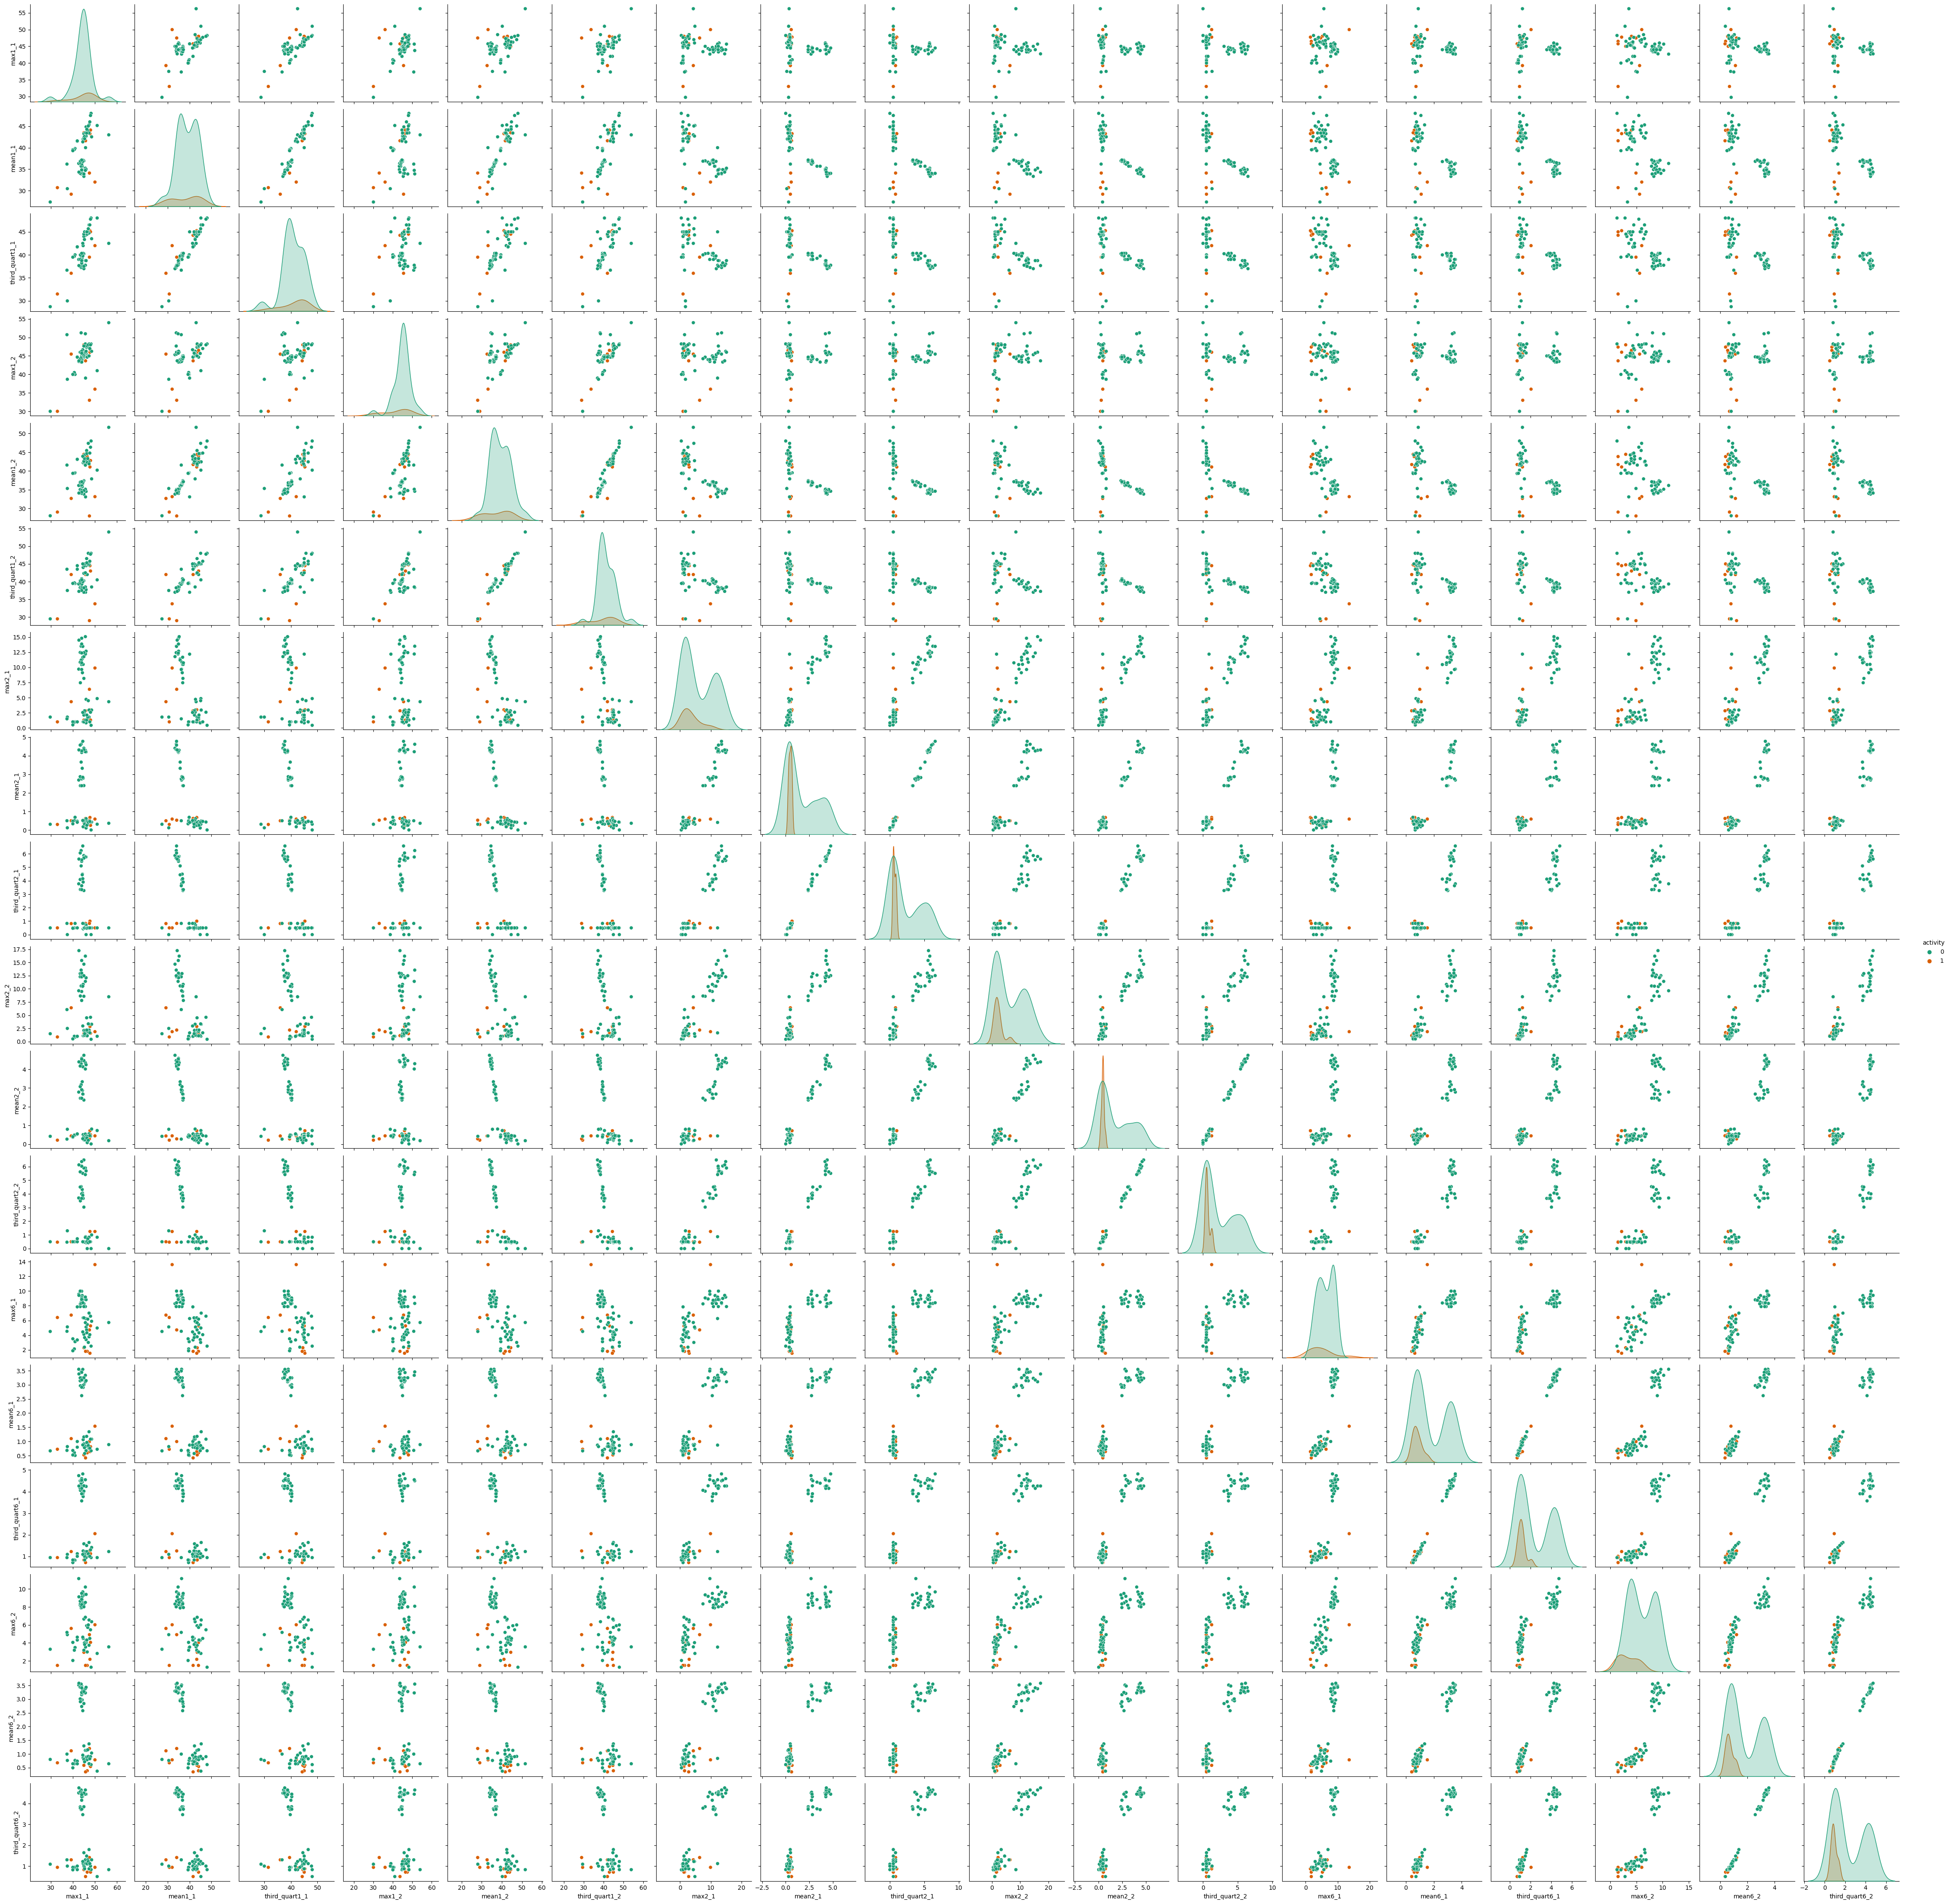

In [31]:
%matplotlib inline
sns.pairplot(new_df, kind='scatter', hue="activity", palette="Dark2")

<font color="blue"><strong>Inference</strong></font> - Based on the 2 above graphs, we can conclude that even after splitting the time-series into 2 equal halves and re-calculating the mean,maximum and third_quartiles for the halves separately, there isn't a signficant difference in the former and the latter graphs.

#### iii. Time Series Segments

In [32]:
def get_feature_names(data):
    names = []
    for num in data:
        names.append('Feature'+str(num))
    return names

In [33]:
# adding column activity with an assumption that 1 = bending and 0 = non-bending
actv = [1]*9
actv.extend([0]*60)
y_train = pd.DataFrame(actv,columns=['activity'])
for l in range(1,21):
    print(f'L Value - {l}')
    flist = []
    for tdf in train_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        flist.append(f.extract_features_by_parts())
    fnames = get_feature_names(list(range(0,len(flist[0]))))
    x_train = pd.DataFrame(flist,columns=fnames)
    model = LogisticRegression()
    model.fit(x_train,y_train)
    rfe_model = RFECV(model, step = 1, cv = 5, scoring='accuracy')
    rfe_model = rfe_model.fit(x_train, y_train)
    print(f'P Value(number of best features) - {rfe_model.n_features_}')
    F1_Score = f1_score(y_train, rfe_model.predict(x_train))
    print(f'F1 Score - {F1_Score}')
    print(f'Best features - {x_train.columns[rfe_model.support_]}')
    data = x_train
    data['activity'] = actv
    temp = ' + '.join(fnames)
    formula = 'activity ~ '+temp
    pval_model = smf.glm(formula = formula, data=data, family=sm.families.Binomial()).fit(maxiter=5)
    print('p-values - ')
    print(pval_model.pvalues)
    print('\n')

L Value - 1
P Value(number of best features) - 14
F1 Score - 1.0
Best features - Index(['Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature5', 'Feature7',
       'Feature8', 'Feature11', 'Feature12', 'Feature13', 'Feature14',
       'Feature15', 'Feature16', 'Feature17'],
      dtype='object')
p-values - 
Intercept    0.928807
Feature0     0.729722
Feature1     0.891574
Feature2     0.910614
Feature3     0.890974
Feature4     0.595110
Feature5     0.626647
Feature6     0.790990
Feature7     0.734928
Feature8     0.656000
Feature9     0.946729
Feature10    0.943037
Feature11    0.949655
Feature12    0.750871
Feature13    0.357883
Feature14    0.508910
Feature15    0.682291
Feature16    0.904257
Feature17    0.967202
dtype: float64


L Value - 2
P Value(number of best features) - 4
F1 Score - 1.0
Best features - Index(['Feature13', 'Feature24', 'Feature25', 'Feature26'], dtype='object')
p-values - 
Intercept    0.904583
Feature0     0.957990
Feature1     0.876914
Feature2     0.9072

P Value(number of best features) - 1
F1 Score - 0.8750000000000001
Best features - Index(['Feature172'], dtype='object')
p-values - 
Intercept     0.999279
Feature0      0.980640
Feature1      0.995525
Feature2      0.990890
Feature3      0.957914
                ...   
Feature247    0.984519
Feature248    0.999064
Feature249    0.999501
Feature250    0.977357
Feature251    0.996196
Length: 253, dtype: float64


L Value - 15
P Value(number of best features) - 75
F1 Score - 1.0
Best features - Index(['Feature16', 'Feature17', 'Feature18', 'Feature21', 'Feature24',
       'Feature25', 'Feature26', 'Feature27', 'Feature28', 'Feature29',
       'Feature30', 'Feature31', 'Feature32', 'Feature33', 'Feature34',
       'Feature35', 'Feature37', 'Feature40', 'Feature54', 'Feature57',
       'Feature66', 'Feature72', 'Feature75', 'Feature78', 'Feature84',
       'Feature87', 'Feature91', 'Feature101', 'Feature108', 'Feature110',
       'Feature118', 'Feature121', 'Feature122', 'Feature128', 'Fea

choosing l-value with highest F1 score and the lowest P Value.
1. l-value: 2
2. P Value: 4
3. Best features: Int64Index([13, 24, 25, 26], dtype='int64')

Cross-validation evaluates the performance of a logistic regression model. RFECV is a better method than p-values for feature selection in regression models, as it can help to improve model accuracy and reduce overfitting, particularly in high-dimensional datasets. Thereby, overcomming model bias and inaccuracy that the latter would have resulted in.

#### iv. Confusion Matrix

In [34]:
new_train_df = []
for tdf in train_list:
    f = SplittedFeatures(tdf,2,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    new_train_df.append(f.extract_features_by_parts())
fnam = get_feature_names(list(range(0,len(new_train_df[0]))))
best_x_all = pd.DataFrame(new_train_df,columns=fnam)
best_x_df = best_x_all.iloc[:, [13, 24, 25, 26]]
# adding column activity with an assumption that 1 = bending and 0 = non-bending
best_y_df = [1]*9
best_y_df.extend([0]*60)

In [35]:
best_data = best_x_df
best_data['activity'] = best_y_df
formula = 'activity ~ Feature13 + Feature24 + Feature25 + Feature26'
p_model = smf.glm(formula = formula, data=best_data, family=sm.families.Binomial()).fit(maxiter=10)

print(f'P-Values: {p_model.pvalues}')

lmodel = LogisticRegression()
lmodel.fit(best_x_df,best_y_df)
y_predict = lmodel.predict(best_x_df)
conf_mat = metrics.confusion_matrix(best_y_df, y_predict)

print(f'confusion matrix: {conf_mat}')

y_score = lmodel.fit(best_x_df, best_y_df).decision_function(best_x_df)

fp_rate,tp_rate,threshold = roc_curve(best_y_df, y_score) 
roc_auc = auc(fp_rate,tp_rate)
print(f'AUC: {roc_auc}')

P-Values: Intercept    0.426485
Feature13    0.525544
Feature24    0.683162
Feature25    0.610568
Feature26    0.843017
dtype: float64
confusion matrix: [[60  0]
 [ 0  9]]
AUC: 1.0


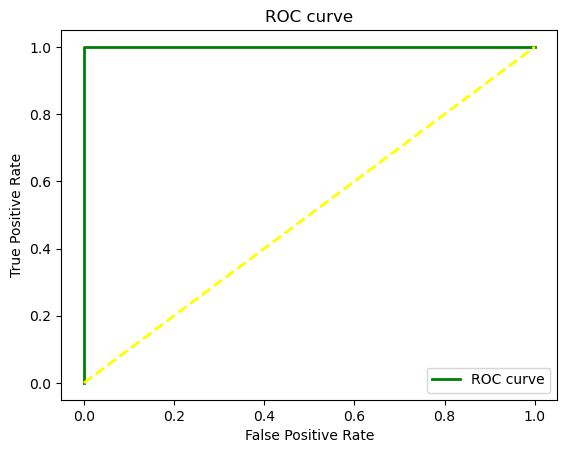

In [36]:
plt.pyplot.plot(fp_rate,tp_rate, lw=2, color="green",label='ROC curve' % roc_auc)
plt.pyplot.plot([0, 1], [0, 1], lw=2, color="yellow",linestyle='--')
plt.pyplot.xlabel('False Positive Rate')
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.title('ROC curve')
plt.pyplot.legend()
plt.pyplot.show()

#### v. Test Classifier

In [37]:
best_ty = [1]*4
best_ty.extend([0]*15)
test_list = []
for folder,files in test_data.items():
    test_list.extend(files)
best_test_y = pd.DataFrame(best_ty,columns=['activity'])

In [48]:
best_x_all = pd.DataFrame(new_train_df,columns=list(range(0,len(new_train_df[0]))))
best_x_df = best_x_all1.iloc[:, [13, 24, 25, 26]]
# adding column activity with an assumption that 1 = bending and 0 = non-bending
best_y_df = [1]*9
best_y_df.extend([0]*60)

<font color="blue">Best Features</font>

In [49]:
best_tx = []
for tdf in test_list:
    f = SplittedFeatures(tdf,2,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    best_tx.append(f.extract_features_by_parts())
best_test_x = pd.DataFrame(best_tx,columns=list(range(0,len(new_train_df[0]))))
best_test_x = best_test_x.iloc[:, [13, 24, 25, 26]]

In [50]:
lreg = LogisticRegression()
rfecv_lreg = RFECV(lreg,step=1,cv=5,scoring="accuracy")
rfecv_lreg = rfecv_lreg.fit(best_x_df,best_y_df)

lreg_train_score = rfecv_lreg.score(best_x_df,best_y_df)
lreg_test_score = rfecv_lreg.score(best_test_x,best_test_y)

print(f'Best Features - Training Score: {lreg_train_score}')
print(f'Best Features - Test Score: {lreg_test_score}')

Best Features - Training Score: 1.0
Best Features - Test Score: 0.9473684210526315


<font color="blue">All Features</font>

In [51]:
best_tx_all = []
for tdf in test_list:
    f = SplittedFeatures(tdf,2,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    best_tx_all.append(f.extract_features_by_parts())
best_test_all_x = pd.DataFrame(best_tx_all,columns=list(range(0,len(new_train_df[0]))))

In [52]:
lreg_all = LogisticRegression()
rfecv_all = RFECV(lreg_all,step=1,cv=5,scoring="accuracy")
rfecv_all = rfecv_all.fit(best_x_all,best_y_df)

lreg_tr_all_scr = rfecv_all.score(best_x_all,best_y_df)
lreg_ts_all_scr = rfecv_all.score(best_test_all_x,best_test_y)

print(f'All Features - Training Score: {lreg_tr_all_scr}')
print(f'All Features - Test Score: {lreg_ts_all_scr}')

All Features - Training Score: 1.0
All Features - Test Score: 0.9473684210526315


As the accuracy of the test model in both cases is over 90%, we can say that we have good model.

#### vi. Separation

Yes, the classes seem to be well-separated and causing instability in calculating logistic regression parameters.

#### vii. Imbalance

<font color="blue">All Features</font>

In [53]:
over_sampler = SMOTE()
x1_data, y1_data = over_sampler.fit_resample(best_x_all,best_y_df)
lreg3 = LogisticRegression()
lreg3.fit(x1_data,y1_data)
y_predict2 = lreg3.predict(best_test_all_x)
conf_matrix2 = metrics.confusion_matrix(best_test_y, y_predict2)
print(f'confusion matrix: {conf_matrix2}')
y_score3 = lreg3.fit(x1_data, y1_data).decision_function(x1_data)
fp2_rate,tp2_rate,threshold = roc_curve(y1_data, y_score3) 
roc_auc2 = auc(fp2_rate,tp2_rate)

confusion matrix: [[15  0]
 [ 0  4]]


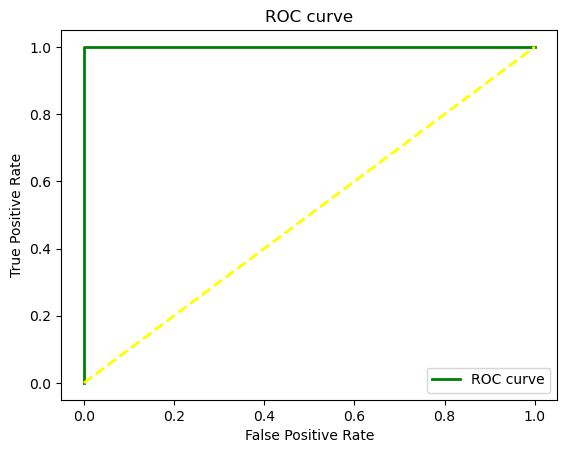

In [54]:
plt.pyplot.plot(fp2_rate,tp2_rate, lw=2, color="green",label='ROC curve' % roc_auc2)
plt.pyplot.plot([0, 1], [0, 1], lw=2, color="yellow",linestyle='--')
plt.pyplot.xlabel('False Positive Rate')
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.title('ROC curve')
plt.pyplot.legend()
plt.pyplot.show()

<font color="blue">Best Features</font>

In [55]:
over_sampler = SMOTE()
x_data, y_data = over_sampler.fit_resample(best_x_df,best_y_df)
lreg2 = LogisticRegression()
lreg2.fit(x_data,y_data)
y_predict1 = lreg2.predict(best_test_x)
conf_matrix1 = metrics.confusion_matrix(best_test_y, y_predict1)
print(f'confusion matrix: {conf_matrix1}')
y_score2 = lreg2.fit(x_data, y_data).decision_function(x_data)
fp1_rate,tp1_rate,threshold = roc_curve(y_data, y_score2) 
roc_auc1 = auc(fp1_rate,tp1_rate)

confusion matrix: [[14  1]
 [ 1  3]]


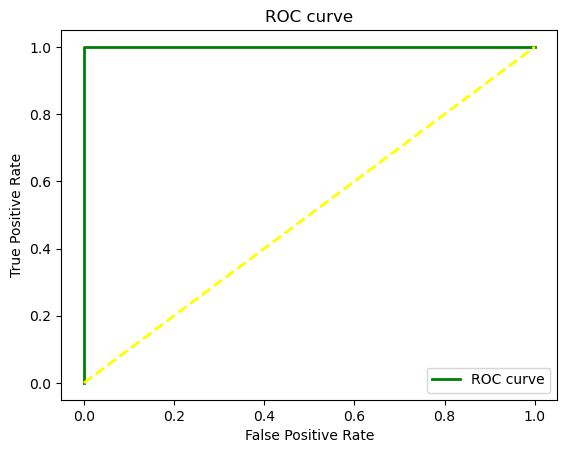

In [56]:
plt.pyplot.plot(fp1_rate,tp1_rate, lw=2, color="green", label='ROC curve' % roc_auc1)
plt.pyplot.plot([0, 1], [0, 1], lw=2, color="yellow", linestyle='--')
plt.pyplot.xlabel('False Positive Rate')
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.title('ROC curve')
plt.pyplot.legend()
plt.pyplot.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [57]:
# adding column activity with an assumption that 1 = bending and 0 = non-bending
actv = [1]*9
actv.extend([0]*60)
l1_y_train = pd.DataFrame(actv,columns=['activity'])
fin_data = []
for l in range(1,21):
    flist = []
    for tdf in train_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        flist.append(f.extract_features_by_parts())
    l1_x_train = pd.DataFrame(flist,columns=list(range(0,len(flist[0]))))
    l1_x_norm = preprocessing.scale(l1_x_train)
    l1_model = LogisticRegressionCV(penalty='l1', cv = 5, solver='liblinear', multi_class = "ovr",scoring = 'accuracy',refit="True").fit(l1_x_norm, l1_y_train)
    l1_score = l1_model.score(l1_x_norm,l1_y_train)
    fin_data.append([l,l1_score])
fin_df = pd.DataFrame(fin_data,columns=['L Value','Model Accuracy'])

In [58]:
fin_df

L Value  Model Accuracy
0         1        0.985507
1         2        0.956522
2         3        0.971014
3         4        0.971014
4         5        1.000000
5         6        0.971014
6         7        0.985507
7         8        1.000000
8         9        1.000000
9        10        0.985507
10       11        1.000000
11       12        1.000000
12       13        1.000000
13       14        1.000000
14       15        1.000000
15       16        1.000000
16       17        1.000000
17       18        1.000000
18       19        1.000000
19       20        1.000000

#### ii. Comparison

<ul>
    <li>The L1-penalized model provides a more accurate model on cross-validation</li>
    <li>Implementation wise L1-regularization is more user friendly, we don't have to pick best features based on the L, the library does that for us</li>
    <li>Computation Intensity wise, L1-regularization is better as we don't have to make separate computations to select features</li>
</ul>

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [59]:
# 1 = bending | 2 = cycling | 3 = lying | 4 = sitting | 5 = standing | 6 = walking
activity_dict = {'cycling':2,'lying':3,'sitting':4,'standing':5,'walking':6}
def generate_multi_case_y(dataset,multi_y):
    for folder,files in dataset.items():
        if 'bending' not in folder:
            multi_y.extend([activity_dict.get(folder)]*len(files))
    multi_y_df = pd.DataFrame(multi_y,columns=['activity'])
    return multi_y_df

In [60]:
multi_train_y = [1]*9
multi_tr_y = generate_multi_case_y(train_data,multi_train_y)
multi_test_y = [1]*4
multi_ts_y = generate_multi_case_y(test_data,multi_test_y)

In [61]:
multi_tr_y

activity
0          1
1          1
2          1
3          1
4          1
..       ...
64         6
65         6
66         6
67         6
68         6

[69 rows x 1 columns]

In [62]:
multi_ts_y

activity
0          1
1          1
2          1
3          1
4          2
5          2
6          2
7          3
8          3
9          3
10         4
11         4
12         4
13         5
14         5
15         5
16         6
17         6
18         6

In [63]:
score_card = []
for l in range(1,21):
    mtrain_list = []
    for tdf in train_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        mtrain_list.append(f.extract_features_by_parts())
    mx_train = pd.DataFrame(mtrain_list,columns=list(range(0,len(mtrain_list[0]))))
    mtest_list = []
    for tdf in test_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        mtest_list.append(f.extract_features_by_parts())
    mx_test = pd.DataFrame(mtest_list,columns=list(range(0,len(mtest_list[0]))))
    multi_model = LogisticRegressionCV(penalty = 'l1', solver='saga', cv=5, multi_class='multinomial', scoring = 'accuracy').fit(mx_train,multi_tr_y)
    multi_score = multi_model.score(mx_test,multi_ts_y)
    multi_error = 1 - multi_score
    score_card.append([l,multi_score,multi_error])
score_df = pd.DataFrame(score_card,columns=['L Values','Model Accuracy','Test Error'])

In [64]:
score_df

L Values  Model Accuracy  Test Error
0          1        0.947368    0.052632
1          2        0.894737    0.105263
2          3        0.842105    0.157895
3          4        0.894737    0.105263
4          5        0.894737    0.105263
5          6        0.842105    0.157895
6          7        0.842105    0.157895
7          8        0.842105    0.157895
8          9        0.947368    0.052632
9         10        0.894737    0.105263
10        11        0.842105    0.157895
11        12        0.842105    0.157895
12        13        0.842105    0.157895
13        14        0.842105    0.157895
14        15        0.842105    0.157895
15        16        0.842105    0.157895
16        17        0.842105    0.157895
17        18        0.842105    0.157895
18        19        0.894737    0.105263
19        20        0.842105    0.157895

In [65]:
# Going with L = 1 **best performance as shown above
mtrain_list = []
for tdf in train_list:
    f = SplittedFeatures(tdf,1,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    mtrain_list.append(f.extract_features_by_parts())
mx_train = pd.DataFrame(mtrain_list,columns=list(range(0,len(mtrain_list[0]))))
mtest_list = []
for tdf in test_list:
    f = SplittedFeatures(tdf,1,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    mtest_list.append(f.extract_features_by_parts())
mx_test = pd.DataFrame(mtest_list,columns=list(range(0,len(mtest_list[0]))))
rmodel = LogisticRegressionCV(penalty = 'l1', solver='saga', cv=5, multi_class='multinomial', scoring = 'accuracy').fit(mx_train, multi_tr_y)
rscore = rmodel.score(mx_test, multi_ts_y)
y_test_predict = rmodel.predict(mx_test)

rc_matrix = metrics.confusion_matrix(multi_ts_y, y_test_predict, labels=[0,1,2,3,4,5])
print(f'confusion matrix: \n {rc_matrix}')

confusion matrix: 
 [[0 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 1 0 2]]


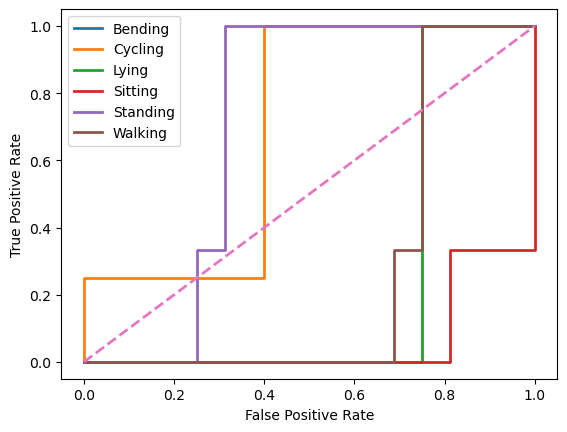

In [66]:
my_scores = rmodel.decision_function(mx_test)
tp_values = dict()
fp_values = dict()
roc_auc = dict()
for i in range(6):
    fp_values[i], tp_values[i],_ = roc_curve(multi_ts_y, my_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fp_values[i], tp_values[i])
plt.pyplot.figure()
for i in range(6):
    name = ''
    if i == 0:
        name = 'Bending'
    elif i == 1:
        name = 'Cycling'
    elif i == 2:
        name = 'Lying'
    elif i == 3:
        name = 'Sitting'
    elif i == 4:
        name = 'Standing'
    elif i == 5:
        name = 'Walking'  
    plt.pyplot.plot(fp_values[i],tp_values[i],lw=2,label=f'{name}'%roc_auc[i])
plt.pyplot.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.pyplot.xlabel('False Positive Rate')
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.legend()
plt.pyplot.show()

#### ii. Naive Bayes

<font color="blue">Gaussian Distribution</font>

In [67]:
gaus_scard = []
for l in range(1,21):
    mtrain_list = []
    for tdf in train_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        mtrain_list.append(f.extract_features_by_parts())
    mx_train = pd.DataFrame(mtrain_list,columns=list(range(0,len(mtrain_list[0]))))
    mtest_list = []
    for tdf in test_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        mtest_list.append(f.extract_features_by_parts())
    mx_test = pd.DataFrame(mtest_list,columns=list(range(0,len(mtest_list[0]))))
    gaus_model = GaussianNB()
    gaus_model.fit(mx_train,multi_tr_y)
    gaus_score = gaus_model.score(mx_test,multi_ts_y)
    gaus_scard.append([l,gaus_score,1-gaus_score])
gaus_scr_df = pd.DataFrame(gaus_scard,columns=['L Value','Model Accuracy','Test Error'])

In [68]:
gaus_scr_df

L Value  Model Accuracy  Test Error
0         1        1.000000    0.000000
1         2        0.947368    0.052632
2         3        0.894737    0.105263
3         4        0.894737    0.105263
4         5        0.894737    0.105263
5         6        0.842105    0.157895
6         7        0.894737    0.105263
7         8        0.894737    0.105263
8         9        0.894737    0.105263
9        10        0.894737    0.105263
10       11        0.894737    0.105263
11       12        0.894737    0.105263
12       13        0.894737    0.105263
13       14        0.894737    0.105263
14       15        0.894737    0.105263
15       16        0.894737    0.105263
16       17        0.894737    0.105263
17       18        0.894737    0.105263
18       19        0.894737    0.105263
19       20        0.894737    0.105263

In [69]:
#l = 1
mtrain_list = []
for tdf in train_list:
    f = SplittedFeatures(tdf,1,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    mtrain_list.append(f.extract_features_by_parts())
mx_train = pd.DataFrame(mtrain_list,columns=list(range(0,len(mtrain_list[0]))))
mtest_list = []
for tdf in test_list:
    f = SplittedFeatures(tdf,1,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    mtest_list.append(f.extract_features_by_parts())
mx_test = pd.DataFrame(mtest_list,columns=list(range(0,len(mtest_list[0]))))
gmodel = GaussianNB().fit(mx_train, multi_tr_y)
gscore = gmodel.score(mx_test, multi_ts_y)
y_tst_pred = gmodel.predict(mx_test)

rc3_matrix = metrics.confusion_matrix(multi_ts_y, y_tst_pred, labels=[0,1,2,3,4,5])
print(f'confusion matrix: \n {rc3_matrix}')

confusion matrix: 
 [[0 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


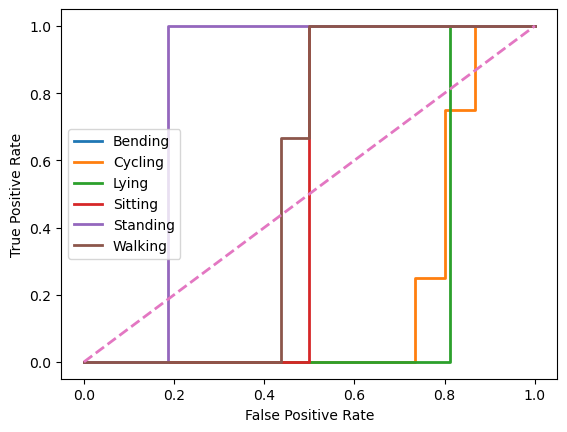

In [70]:
gy_scores = gmodel.predict_log_proba(mx_test)
gtp_values = dict()
gfp_values = dict()
groc_auc = dict()
for i in range(6):
    gfp_values[i], gtp_values[i],_ = roc_curve(multi_ts_y, gy_scores[:, i],pos_label=i)
    groc_auc[i] = auc(gfp_values[i], gtp_values[i])
plt.pyplot.figure()
for i in range(6):
    name = ''
    if i == 0:
        name = 'Bending'
    elif i == 1:
        name = 'Cycling'
    elif i == 2:
        name = 'Lying'
    elif i == 3:
        name = 'Sitting'
    elif i == 4:
        name = 'Standing'
    elif i == 5:
        name = 'Walking'    
    plt.pyplot.plot(gfp_values[i],gtp_values[i],lw=2,label=f'{name}'%groc_auc[i])
plt.pyplot.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.pyplot.xlabel('False Positive Rate')
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.legend()
plt.pyplot.show()

<font color="blue">Multinomial Distribution</font>

In [71]:
mnom_scard = []
for l in range(1,21):
    mtrain_list = []
    for tdf in train_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        mtrain_list.append(f.extract_features_by_parts())
    mx_train = pd.DataFrame(mtrain_list,columns=list(range(0,len(mtrain_list[0]))))
    mtest_list = []
    for tdf in test_list:
        f = SplittedFeatures(tdf,l,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        mtest_list.append(f.extract_features_by_parts())
    mx_test = pd.DataFrame(mtest_list,columns=list(range(0,len(mtest_list[0]))))
    mnom_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    mnom_model.fit(mx_train,multi_tr_y)
    mnom_score = mnom_model.score(mx_test,multi_ts_y)
    mnom_scard.append([l,mnom_score,1-mnom_score])
mnom_scr_df = pd.DataFrame(mnom_scard,columns=['L Value','Model Accuracy','Test Error'])

In [72]:
mnom_scr_df

L Value  Model Accuracy  Test Error
0         1        0.947368    0.052632
1         2        0.894737    0.105263
2         3        0.894737    0.105263
3         4        0.947368    0.052632
4         5        0.947368    0.052632
5         6        0.947368    0.052632
6         7        0.947368    0.052632
7         8        0.947368    0.052632
8         9        0.947368    0.052632
9        10        0.947368    0.052632
10       11        0.947368    0.052632
11       12        0.947368    0.052632
12       13        0.947368    0.052632
13       14        0.947368    0.052632
14       15        0.947368    0.052632
15       16        0.947368    0.052632
16       17        0.947368    0.052632
17       18        0.947368    0.052632
18       19        0.947368    0.052632
19       20        0.947368    0.052632

In [73]:
#l = 4
mtrain_list = []
for tdf in train_list:
    f = SplittedFeatures(tdf,4,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    mtrain_list.append(f.extract_features_by_parts())
mx_train = pd.DataFrame(mtrain_list,columns=list(range(0,len(mtrain_list[0]))))
mtest_list = []
for tdf in test_list:
    f = SplittedFeatures(tdf,4,['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
    mtest_list.append(f.extract_features_by_parts())
mx_test = pd.DataFrame(mtest_list,columns=list(range(0,len(mtest_list[0]))))
mnom_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None).fit(mx_train, multi_tr_y)
mnom_score = mnom_model.score(mx_test, multi_ts_y)
y_tst_pred4 = mnom_model.predict(mx_test)

rc4_matrix = metrics.confusion_matrix(multi_ts_y, y_tst_pred4, labels=[0,1,2,3,4,5])
print(f'confusion matrix: \n {rc4_matrix}')

confusion matrix: 
 [[0 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 2 1]
 [0 0 0 0 0 3]]


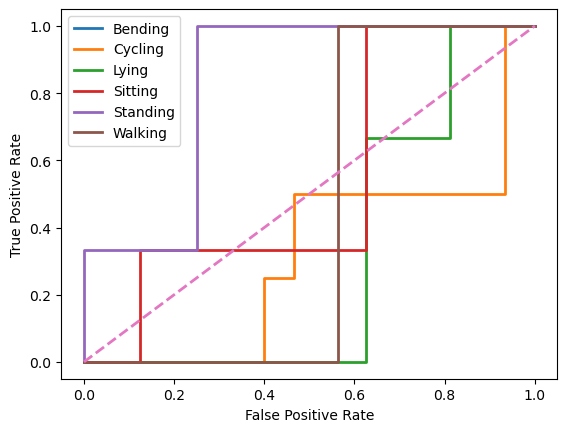

In [74]:
mnom_y_scores = mnom_model.predict_log_proba(mx_test)
mtp_values = dict()
mfp_values = dict()
mroc_auc = dict()
for i in range(6):
    mfp_values[i], mtp_values[i],_ = roc_curve(multi_ts_y, mnom_y_scores[:, i],pos_label=i)
    mroc_auc[i] = auc(mfp_values[i], mtp_values[i])
plt.pyplot.figure()
for i in range(6):
    name = ''
    if i == 0:
        name = 'Bending'
    elif i == 1:
        name = 'Cycling'
    elif i == 2:
        name = 'Lying'
    elif i == 3:
        name = 'Sitting'
    elif i == 4:
        name = 'Standing'
    elif i == 5:
        name = 'Walking'    
    plt.pyplot.plot(mfp_values[i],mtp_values[i],lw=2,label=f'{name}'%mroc_auc[i])
plt.pyplot.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.pyplot.xlabel('False Positive Rate')
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.legend()
plt.pyplot.show()

#### ii. Comparison

In [75]:
print('x = Gaussian and y = Multinomial')
gaus_scr_df.reset_index(drop=True).merge(mnom_scr_df.reset_index(drop=True), left_index=True, right_index=True)

x = Gaussian and y = Multinomial


L Value_x  Model Accuracy_x  Test Error_x  L Value_y  Model Accuracy_y  \
0           1          1.000000      0.000000          1          0.947368   
1           2          0.947368      0.052632          2          0.894737   
2           3          0.894737      0.105263          3          0.894737   
3           4          0.894737      0.105263          4          0.947368   
4           5          0.894737      0.105263          5          0.947368   
5           6          0.842105      0.157895          6          0.947368   
6           7          0.894737      0.105263          7          0.947368   
7           8          0.894737      0.105263          8          0.947368   
8           9          0.894737      0.105263          9          0.947368   
9          10          0.894737      0.105263         10          0.947368   
10         11          0.894737      0.105263         11          0.947368   
11         12          0.894737      0.105263         12          0.947368   
12         13          0.894737      0.105263         13          0.947368   
13         14          0.894737      0.105263         14          0.947368   
14         15          0.894737      0.105263         15          0.947368   
15         16          0.894737      0.105263         16          0.947368   
16         17          0.894737      0.105263         17          0.947368   
17         18          0.894737      0.105263         18          0.947368   
18         19          0.894737      0.105263         19          0.947368   
19         20          0.894737      0.105263         20          0.947368   

    Test Error_y  
0       0.052632  
1       0.105263  
2       0.105263  
3       0.052632  
4       0.052632  
5       0.052632  
6       0.052632  
7       0.052632  
8       0.052632  
9       0.052632  
10      0.052632  
11      0.052632  
12      0.052632  
13      0.052632  
14      0.052632  
15      0.052632  
16      0.052632  
17      0.052632  
18      0.052632  
19      0.052632

<font color="blue">Based on the above table, we can conclude that Naive Bayes Classifier works better with multinomial distribution. Naive Bayes Classifier with multinomial distribution works better than Logistic Regression Classifier in our case.</font>